In [3]:
import os
import re
import json
import pandas as pd 
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Tuple, Optional
import pycocotools.mask as mask_util

from src.data_utils import process_damage_instances, ImageInstances, Instance
from src.utils import compute_damage_features
from src.claim_utils import aggregate_by_imbag
from ai2_interfaces.io import read_instance_dataset_from_coco_file

In [4]:
### Process instant quote predictions
iq_damageseg_path = '/userdata/Nicolas.Busca/tds/preds_instant_quote_test_zkmuq92y.json'
damageseg_instances, damageseg_categories = read_instance_dataset_from_coco_file(iq_damageseg_path)

In [5]:
panelseg_path = '/userdata/Nicolas.Busca/notebooks/panelseg/instant_quote/panels_instant_quote.json'
panelseg_instances, panelseg_categories = read_instance_dataset_from_coco_file(panelseg_path)

In [6]:
# Constants
PANELS_IN_SCOPE = [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 20, 21]
SCORE_THRESHOLD = 0.5

In [ ]:
### 1 - only select the panelsegs that have a match inside RLH df
### 2 - do NMS on damageseg - we're observing it. Do it just to be safe
### 3 - merge damages of the same type into a single mask? Don't process them one by one 
### 4 - delete out of scope panels
### 5 - actually only keep panels that are INSIDE the panel

In [7]:
df = pd.read_csv('/userdata/Nicolas.Busca/tds/instant_quote_eval-Sep2024-labour_hours_test.csv')
## parse the image ids checking for malformed entries
image_ids = set(df["media_ids_without_pii"].map(lambda i: json.loads(i) if isinstance(i, str) else None).explode("media_ids_without_pii"))

## image ids from predictions
with open('/userdata/Nicolas.Busca/tds/preds_instant_quote_test_zkmuq92y.json') as f:
    data = json.load(f)
pred_ids = set([d['id'] for d in data['images']])

## Matching images
print("Matches:", len(pred_ids.intersection(image_ids)), "out of", len(image_ids))
keep_ids = pred_ids.intersection(image_ids)

Matches: 267356 out of 349914


In [8]:
del data

In [6]:
df.head()

Unnamed: 0                                                 id  \
0           0  000314a8a806dec94951b94ae3e2ebe3142b49ed6bbdfe...   
1           1  000761a5ad41d8a0e93f12287389287f3245930a0ac081...   
2           2  000cf4bc9b8b2de268940e9c0ea77164ae90f3a6b7cd39...   
3           3  000f987adc6a9e531e7e2f4c4e7c89bdabf58defdb6ed9...   
4           4  0012f116b003b0a301051518171faa83ba3444cb4eb89b...   

                     feature_subject_id  feature_type  version  \
0  fe926b9a-ec67-4fd4-84c0-2b300bd11715  labour_hours        1   
1  2067a7ac-35e0-4f1c-a10f-93fbb4b74cc2  labour_hours        1   
2  2d267c0d-5986-4c03-8e0b-8d7c4a1dd8f5  labour_hours        1   
3  634671f4-3612-4f5e-9d99-330a14929bdf  labour_hours        1   
4  5fb6388e-1fad-4138-8959-e9e8fa82b8a5  labour_hours        1   

                                             feature               created_at  \
0  {"bbumper":null,"blwing":null,"bonnet":2,"boot...  2024-11-12 16:11:53.019   
1  {"bbumper":null,"blwing":null,"bonnet":null,"b...  2024-11-12 16:11:53.019   
2  {"bbumper":null,"blwing":null,"bonnet":null,"b...  2024-11-12 16:11:53.019   
3  {"bbumper":null,"blwing":null,"bonnet":5,"boot...  2024-11-12 16:11:53.019   
4  {"bbumper":null,"blwing":null,"bonnet":null,"b...  2024-11-12 16:11:53.019   

                       source                 source_metadata  \
0  tds_dataset_ingestion_code  {"generating_code":"Notebook"}   
1  tds_dataset_ingestion_code  {"generating_code":"Notebook"}   
2  tds_dataset_ingestion_code  {"generating_code":"Notebook"}   
3  tds_dataset_ingestion_code  {"generating_code":"Notebook"}   
4  tds_dataset_ingestion_code  {"generating_code":"Notebook"}   

   does_contain_pii  ...                                     asset_metadata  \
0             False  ...  {"make":"Nissan","model":"Pathfinder SV 4WD 4D...   
1             False  ...  {"make":"Toyota","model":"RAV4 LE AWD 4D UTV 4...   
2             False  ...  {"make":"Honda","model":"Accord LX Premium 4 D...   
3             False  ...  {"make":"Hyundai","model":"Tucson","num_doors"...   
4             False  ...  {"make":"Volkswagen","model":"Jetta","num_door...   

                       data_context_id              document_metadata  \
0    RR_geico_arx_prod_extract_Sep2024  {"estimatics_platform":"ccc"}   
1  RR_geico_subro_prod_extract_Sep2024  {"estimatics_platform":"ccc"}   
2  RR_geico_subro_prod_extract_Sep2024  {"estimatics_platform":"ccc"}   
3      RR_dgig_qc_prod_extract_Sep2024  {"estimatics_platform":"ccc"}   
4      RR_dgig_qc_prod_extract_Sep2024  {"estimatics_platform":"ccc"}   

  media_metadata      document_created_at data_feature_level  \
0            NaN  2024-10-01 12:37:25.482     document-level   
1            NaN  2024-10-01 12:41:18.301     document-level   
2            NaN  2024-10-01 12:41:18.301     document-level   
3            NaN  2024-10-01 12:46:05.480     document-level   
4            NaN  2024-10-01 12:46:05.480     document-level   

                                media_paths_with_pii  \
0  ["s3://tractable-us-geicoarx-review-data/fe926...   
1  ["s3://tractable-us-geico-review-data/2067a7ac...   
2  ["s3://tractable-us-geico-review-data/2d267c0d...   
3  ["s3://tractable-us-desjardins-review-data/854...   
4  ["s3://tractable-us-desjardins-review-data/859...   

                             media_paths_without_pii  \
0  ["s3://tractable-us-geicoarx-review-images-ano...   
1  ["s3://tractable-us-geico-review-images-anonym...   
2  ["s3://tractable-us-geico-review-images-anonym...   
3  ["s3://tractable-us-desjardins-review-images/d...   
4  ["s3://tractable-us-desjardins-review-images/e...   

                                  media_ids_with_pii  \
0   ["Claims2-EE9E2B3A-6B0C-469E-BD78-0CF29884AE6F"]   
1  ["estimate_builder_extracted_estimate-20240122...   
2  ["estimate_builder_extracted_estimate-20240321...   
3              ["85422082-020568298_20240228163302"]   
4              ["85952419-020850765_20240605135521"]   

         

In [8]:
list(df.columns)

['Unnamed: 0',
 'id',
 'feature_subject_id',
 'feature_type',
 'version',
 'feature',
 'created_at',
 'source',
 'source_metadata',
 'does_contain_pii',
 'code_lineage_git_url',
 'code_lineage_git_commit',
 'metadata',
 'batch_data_id',
 'client_id',
 'train_val_test',
 'asset_metadata',
 'data_context_id',
 'document_metadata',
 'media_metadata',
 'document_created_at',
 'data_feature_level',
 'media_paths_with_pii',
 'media_paths_without_pii',
 'media_ids_with_pii',
 'media_ids_without_pii']

In [9]:
### Create image_id to feature_id dictionary
import ast

imbag2rlh = dict()
image2imbag = dict()
imbag2client = dict()
for index, row in df.iterrows():
    imbag = row['feature_subject_id']
    images = row['media_ids_without_pii']
    rlhs = row['feature']
    client = row['client_id']

    imbag2client[imbag] = client
    
    if type(images) is float:
        continue
    images = ast.literal_eval(images)
    for image in images:
        image2imbag[image] = imbag
    if rlhs is not None:
        rlhs = json.loads(rlhs)
        imbag2rlh[imbag] = dict()
        for key, val in rlhs.items():
            if val is None:
                continue
            else:
                imbag2rlh[imbag][key] = val
            
imbag2client

{'fe926b9a-ec67-4fd4-84c0-2b300bd11715': 'geico_arx',
 '2067a7ac-35e0-4f1c-a10f-93fbb4b74cc2': 'geico_subro',
 '2d267c0d-5986-4c03-8e0b-8d7c4a1dd8f5': 'geico_subro',
 '634671f4-3612-4f5e-9d99-330a14929bdf': 'dgig_qc',
 '5fb6388e-1fad-4138-8959-e9e8fa82b8a5': 'dgig_qc',
 '40aa584e-89f8-4913-93ce-0cea6097edcd': 'geico_subro',
 'e93fe072-053e-47c7-81d6-840a52614341': 'dgig_oaw',
 'a5d499b3-cb17-40d3-bee5-8499bd952f17': 'dgig_qc',
 '33eda6c6-fb20-403b-b766-2964d4f9b69c': 'geico_arx',
 '950aaf94-1d6e-45ab-8e0c-d8a7b1c1188f': 'geico_arx',
 '7cda3cde-0757-4d46-b3af-2eb3349ae320': 'dgig_qc',
 'f788db37-8ac6-4f78-a456-af2858d9439b': 'geico_arx',
 '3791e6c7-5eec-4ba5-ad35-b6a5803d17e3': 'geico_arx',
 '2e457d0c-07c7-4239-a5f8-4ed46fc4c1d0': 'geico_subro',
 '26f5415d-88b4-4e0c-b1a1-56c23bff48bc': 'geico_subro',
 '1152b734-1747-40fd-8815-fdfe8035479b': 'dgig_qc',
 '60a2afd7-1ce6-4e64-97b4-5a5743da6d4b': 'dgig_qc',
 '71f84071-5a3a-42f8-8f65-7bfd1d5a9da2': 'dgig_oaw',
 'ce5604d6-a87f-4dd2-b700-4dc72f

In [10]:
### ONLY keep panel instances that have RLH
panelseg_instances_keep = [
    instance 
    for instance in tqdm(panelseg_instances)
    if instance.file_name.split('/')[-1].split('.')[0] in keep_ids]

print(len(panelseg_instances))
print(len(panelseg_instances_keep))

100%|█████████████████████████████████████████████████████████████████████████████████| 563661/563661 [00:00<00:00, 1075990.16it/s]

563661
267356


In [12]:
del panelseg_instances

In [2]:
df = pd.read_csv('./IQ_image_level_metrology.csv')
print(len(df))
df.head()

147911


Unnamed: 0                              image_id   panel damage_type  \
0           0  0a5cc64a-2d59-5954-a13c-739f12a1a2d6  frdoor     scratch   
1           1  0a5cc64a-2d59-5954-a13c-739f12a1a2d6  frdoor     scratch   
2           2  0a5cc64a-2d59-5954-a13c-739f12a1a2d6  frdoor     scratch   
3           3  0a5cc64a-2d59-5954-a13c-739f12a1a2d6  frdoor     scratch   
4           4  0a5cc64a-2d59-5954-a13c-739f12a1a2d6  frdoor     scratch   

   damage_size  damage_on_edge  whole_panel_visible  
0     0.154226           False                 True  
1    13.768410           False                 True  
2     0.230806           False                 True  
3     0.013570           False                 True  
4     0.047825           False                 True

In [13]:
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np
from pycocotools import mask as mask_utils

In [14]:
@dataclass
class ImageInstances:
    file_name: str
    height: int
    width: int
    instances: List['Instance']

@dataclass
class Instance:
    bbox: Tuple[int, int, int, int]
    category_id: int
    segmentation: Dict
    id: int
    score: float = 1.0

def process_damage_instances(damage_instances: List[ImageInstances], 
                           panel_instances: List[ImageInstances]) -> Dict:
    """
    Process damage instances by matching them to panels and merging same-type damages.
    Now correctly stores both panel and damage information.
    """
    # Create lookup dictionary for panel instances by filename
    panel_dict = {inst.file_name: inst for inst in panel_instances}
    results = {}
    
    for damage_img in tqdm(damage_instances):
        if damage_img.file_name not in panel_dict:
            continue
            
        panel_img = panel_dict[damage_img.file_name]
        image_matches = {}
        
        # Filter panels and damages
        valid_panels = [
            panel for panel in panel_img.instances 
            if panel.category_id in PANELS_IN_SCOPE
        ]
        
        valid_damages = [
            damage for damage in damage_img.instances 
            if damage.score >= SCORE_THRESHOLD
        ]
        
        # Group damages by category
        damage_by_category = {}
        for damage in valid_damages:
            if damage.category_id not in damage_by_category:
                damage_by_category[damage.category_id] = []
            damage_by_category[damage.category_id].append(damage)
        
        # For each panel, find and merge contained damages
        for panel in valid_panels:
            panel_mask = mask_utils.decode(panel.segmentation)
            panel_damages = {}
            
            # Process each damage category
            for category_id, category_damages in damage_by_category.items():
                contained_damages = []
                
                # Check which damages are contained in this panel
                for damage in category_damages:
                    damage_mask = mask_utils.decode(damage.segmentation)
                    if is_damage_in_panel(damage_mask, panel_mask):
                        contained_damages.append(damage)
                
                # If we found damages in this category, merge them
                if contained_damages:
                    merged_damage = merge_damage_instances(contained_damages)
                    if merged_damage:
                        panel_damages[category_id] = {
                            'panel': panel,  # Store panel instance
                            'damage': merged_damage  # Store damage instance
                        }
            
            if panel_damages:
                image_matches[panel.id] = panel_damages
        
        if image_matches:
            results[damage_img.file_name] = image_matches
    
    return results

def is_damage_in_panel(damage_mask: np.ndarray, panel_mask: np.ndarray) -> bool:
    """
    Check if damage mask is contained within panel mask.
    Uses 90% overlap threshold for robustness.
    """
    intersection = np.logical_and(damage_mask, panel_mask)
    return np.sum(intersection) >= 0.9 * np.sum(damage_mask)

def merge_damage_instances(damages: List[Instance]) -> Optional[Instance]:
    """
    Merge multiple damage instances of the same category into a single instance.
    
    Args:
        damages: List of damage instances to merge
        
    Returns:
        New Instance with merged mask or None if input is empty
    """
    if not damages:
        return None
    
    # Initialize with first damage mask
    merged_mask = mask_utils.decode(damages[0].segmentation)
    
    # Merge all other masks
    for damage in damages[1:]:
        damage_mask = mask_utils.decode(damage.segmentation)
        merged_mask = np.logical_or(merged_mask, damage_mask)
    
    # Compute bounding box for merged mask
    rows = np.any(merged_mask, axis=1)
    cols = np.any(merged_mask, axis=0)
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]
    
    # Create new instance with merged data
    return Instance(
        bbox=(x1, y1, x2 - x1 + 1, y2 - y1 + 1),
        category_id=damages[0].category_id,
        segmentation=mask_utils.encode(np.asfortranarray(merged_mask)),
        id=damages[0].id,  # Use first damage's ID
        score=max(d.score for d in damages)  # Use highest confidence score
    )

In [16]:
matched_results = process_damage_instances(damageseg_instances, panelseg_instances_keep)

100%|███████████████████████████████████████████████████████████████████████████████████| 427657/427657 [1:02:46<00:00, 113.55it/s]


In [17]:
len(matched_results)

139015

### Save results

In [28]:
from pathlib import Path
import numpy as np
import json
from typing import Dict, Any
import pickle
import gzip

def convert_to_serializable(obj):
    """
    Convert object to JSON serializable format.
    Handles NumPy types and other non-serializable objects.
    """
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, tuple):
        return list(obj)
    return obj

def save_results(results: Dict, output_dir: str):
    """
    Save damage analysis results in an efficient format.
    Uses compressed numpy format for masks and JSON for metadata.
    
    Args:
        results: Results dictionary from process_damage_instances
        output_dir: Directory to save the results
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Create a metadata dictionary without the binary mask data
    metadata = {}
    compressed_masks = {}
    
    for image_id, panel_data in results.items():
        metadata[image_id] = {}
        compressed_masks[image_id] = {}
        
        for panel_id, damage_categories in panel_data.items():
            # Convert panel_id to string for JSON compatibility
            panel_id_str = str(panel_id)
            metadata[image_id][panel_id_str] = {}
            compressed_masks[image_id][panel_id_str] = {}
            
            for category_id, damage_inst in damage_categories.items():
                # Convert category_id to string for JSON compatibility
                category_id_str = str(category_id)
                
                # Store metadata with explicit type conversion
                meta_entry = {
                    'category_id': convert_to_serializable(damage_inst.category_id),
                    'id': convert_to_serializable(damage_inst.id),
                    'score': convert_to_serializable(damage_inst.score)
                }
                metadata[image_id][panel_id_str][category_id_str] = meta_entry
                
                # Store compressed mask data
                compressed_masks[image_id][panel_id_str][category_id_str] = damage_inst.segmentation

    # Save metadata as JSON
    with open(output_path / 'metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    # Save compressed masks using gzip pickle
    with gzip.open(output_path / 'masks.pkl.gz', 'wb') as f:
        pickle.dump(compressed_masks, f)

def load_results(input_dir: str) -> Dict:
    """
    Load damage analysis results saved by save_results.
    
    Args:
        input_dir: Directory containing the saved results
        
    Returns:
        Reconstructed results dictionary
    """
    input_path = Path(input_dir)
    
    # Load metadata
    with open(input_path / 'metadata.json', 'r') as f:
        metadata = json.load(f)
    
    # Load compressed masks
    with gzip.open(input_path / 'masks.pkl.gz', 'rb') as f:
        compressed_masks = pickle.load(f)
    
    # Reconstruct the full results dictionary
    results = {}
    for image_id, panel_data in metadata.items():
        results[image_id] = {}
        
        for panel_id, damage_categories in panel_data.items():
            results[image_id][int(panel_id)] = {}
            
            for category_id, meta_entry in damage_categories.items():
                # Create Instance with both metadata and mask
                damage_inst = Instance(
                    category_id=meta_entry['category_id'],
                    segmentation=compressed_masks[image_id][panel_id][category_id],
                    id=meta_entry['id'],
                    score=meta_entry['score']
                )
                results[image_id][int(panel_id)][int(category_id)] = damage_inst
    
    return results

In [29]:
output_dir = './data/IQ_matched_instances_claude_sample2.json'
save_results(matched_results, output_dir)

AttributeError: 'dict' object has no attribute 'category_id'

### Produce features

In [22]:
def compute_damage_features(
    matched_results: Dict,
    panel_name_map: Dict[int, str],
    damage_type_map: Dict[int, str]
) -> pd.DataFrame:
    """
    Compute features from damage and panel masks.
    Updated to handle new data structure with separate panel and damage info.
    
    Args:
        matched_results: Dictionary of format:
            {image_path: {panel_id: {damage_cat_id: {'panel': panel_inst, 'damage': damage_inst}}}}
        panel_name_map: Dictionary mapping panel category IDs to names
        damage_type_map: Dictionary mapping damage category IDs to names
    """
    data = []
    
    for image_path, panels in tqdm(matched_results.items()):
        for panel_id, damage_categories in panels.items():
            for damage_cat_id, instances in damage_categories.items():
                # Get panel and damage instances
                panel_inst = instances['panel']
                damage_inst = instances['damage']
                
                # Decode masks
                panel_mask = mask_utils.decode(panel_inst.segmentation)
                damage_mask = mask_utils.decode(damage_inst.segmentation)
                
                # Compute features
                damage_size = compute_damage_size(damage_mask, panel_mask)
                damage_on_edge = check_damage_on_edge_buffer(damage_mask, panel_mask)
                num_components = count_components(damage_mask)
                rel_x, rel_y = compute_relative_position(damage_mask, panel_mask)
                
                # Check panel visibility
                whole_panel_visible = not touches_image_edge(panel_mask)
                
                data.append({
                    'image_path': image_path,
                    'panel': panel_name_map[panel_inst.category_id],
                    'damage_type': damage_type_map[damage_inst.category_id],
                    'damage_size': damage_size,
                    'damage_on_edge': damage_on_edge,
                    'whole_panel_visible': whole_panel_visible,
                    'num_components': num_components,
                    'relative_x': rel_x,
                    'relative_y': rel_y
                })
    
    return pd.DataFrame(data)

# No changes needed to these helper functions as they work with masks directly
def compute_damage_size(damage_mask: np.ndarray, panel_mask: np.ndarray) -> float:
    """Compute what percentage of panel area is covered by damage."""
    panel_area = np.sum(panel_mask)
    if panel_area == 0:
        return 0.0
    
    damage_area = np.sum(np.logical_and(damage_mask, panel_mask))
    return (damage_area / panel_area) * 100

def check_damage_on_edge(damage_mask: np.ndarray, panel_mask: np.ndarray) -> bool:
    """Check if damage touches the edge of the panel using simple erosion."""
    kernel = np.ones((3, 3), np.uint8)
    eroded_panel = cv2.erode(panel_mask.astype(np.uint8), kernel, iterations=1)
    panel_edge = panel_mask.astype(np.uint8) - eroded_panel
    return np.any(np.logical_and(damage_mask, panel_edge))

def check_damage_on_edge_buffer(damage_mask: np.ndarray, panel_mask: np.ndarray, buffer_size: int = 5) -> bool:
    """
    Check if damage touches or is very close to the edge of the panel.
    
    Args:
        damage_mask: Binary mask of damage
        panel_mask: Binary mask of panel
        buffer_size: Size of buffer zone in pixels (default: 3)
        
    Returns:
        True if damage is on or very close to panel edge, False otherwise
    """
    # Convert masks to uint8
    panel_mask = panel_mask.astype(np.uint8)
    
    # Get panel edge
    kernel = np.ones((3, 3), np.uint8)
    eroded_panel = cv2.erode(panel_mask, kernel, iterations=1)
    panel_edge = panel_mask - eroded_panel
    
    # Create buffer zone around edge
    buffer_kernel = np.ones((buffer_size, buffer_size), np.uint8)
    edge_with_buffer = cv2.dilate(panel_edge, buffer_kernel, iterations=1)
    
    # Check if damage intersects with buffered edge
    return np.any(np.logical_and(damage_mask, edge_with_buffer))

def check_damage_on_edge_v2(damage_mask: np.ndarray, panel_mask: np.ndarray, distance_threshold: int = 3) -> bool:
    """
    Alternative version that checks the minimum distance from damage to panel edge.
    
    Args:
        damage_mask: Binary mask of damage
        panel_mask: Binary mask of panel
        distance_threshold: Maximum distance in pixels to consider "close to edge" (default: 3)
        
    Returns:
        True if damage is within threshold distance of panel edge, False otherwise
    """
    # Get panel edge
    kernel = np.ones((3, 3), np.uint8)
    eroded_panel = cv2.erode(panel_mask.astype(np.uint8), kernel, iterations=1)
    panel_edge = panel_mask.astype(np.uint8) - eroded_panel
    
    # Get edge pixels and damage pixels
    edge_coords = np.argwhere(panel_edge > 0)
    damage_coords = np.argwhere(damage_mask > 0)
    
    if len(edge_coords) == 0 or len(damage_coords) == 0:
        return False
    
    # Compute minimum distance from any damage pixel to any edge pixel
    # Using vectorized operations for speed
    distances = np.min([
        np.sqrt(np.sum((edge_coords - damage_coord) ** 2, axis=1))
        for damage_coord in damage_coords
    ])
    
    return distances <= distance_threshold
    
def compute_relative_position(damage_mask: np.ndarray, panel_mask: np.ndarray) -> Tuple[float, float]:
    """Compute relative position of damage centroid within panel."""
    damage_y, damage_x = np.where(damage_mask)
    if len(damage_x) == 0:
        return 0.5, 0.5
        
    damage_centroid = (np.mean(damage_x), np.mean(damage_y))
    
    panel_y, panel_x = np.where(panel_mask)
    if len(panel_x) == 0:
        return 0.5, 0.5
        
    x_min, x_max = np.min(panel_x), np.max(panel_x)
    y_min, y_max = np.min(panel_y), np.max(panel_y)
    
    rel_x = (damage_centroid[0] - x_min) / (x_max - x_min + 1e-6)
    rel_y = (damage_centroid[1] - y_min) / (y_max - y_min + 1e-6)
    
    return rel_x, rel_y

def count_components(mask: np.ndarray) -> int:
    """Count number of separate damage components."""
    num_labels, _ = cv2.connectedComponents(mask.astype(np.uint8))
    return num_labels - 1  # Subtract 1 for background

# Alternative even simpler approach without using cv2:
def check_damage_on_edge_simple(damage_mask: np.ndarray, panel_mask: np.ndarray) -> bool:
    """
    Simpler version using only NumPy operations.
    Checks if any damage pixels are on panel boundary.
    """
    # Find panel boundary pixels
    panel_boundary = np.zeros_like(panel_mask)
    panel_boundary[:-1, :] |= panel_mask[1:, :] != panel_mask[:-1, :]  # Vertical edges
    panel_boundary[:, :-1] |= panel_mask[:, 1:] != panel_mask[:, :-1]  # Horizontal edges
    
    # Check if damage intersects with boundary
    return np.any(np.logical_and(damage_mask, panel_boundary))

def touches_image_edge(mask: np.ndarray) -> bool:
    """
    Check if mask touches the edge of the image.
    Uses efficient numpy operations checking only the border.
    """
    height, width = mask.shape
    border = np.concatenate([
        mask[0, :],     # top edge
        mask[-1, :],    # bottom edge
        mask[1:-1, 0],  # left edge (excluding corners)
        mask[1:-1, -1]  # right edge (excluding corners)
    ])
    return np.any(border)

# Example usage
def process_and_analyze_damages(
    matched_results: Dict,
    panel_name_map: Dict[int, str],
    damage_type_map: Dict[int, str],
    output_csv: str = None
) -> pd.DataFrame:
    """
    Process damage results and optionally save to CSV.
    
    Args:
        matched_results: Results from damage matching
        panel_name_map: Mapping of panel IDs to names
        damage_type_map: Mapping of damage type IDs to names
        output_csv: Optional path to save CSV file
        
    Returns:
        DataFrame with damage analysis
    """
    # Compute features
    df = compute_damage_features(
        matched_results,
        panel_name_map,
        damage_type_map
    )
    
    # Save if requested
    if output_csv:
        df.to_csv(output_csv, index=False)
    
    return df

In [19]:
import cv2 
import random 
from itertools import islice

def sample_dict(dictionary, n):
    keys = random.sample(list(dictionary.keys()), n)
    return {k: dictionary[k] for k in keys}

matched_results_sample = sample_dict(matched_results, 25000)
image_level_df = compute_damage_features(matched_results, panelseg_categories, damageseg_categories)

100%|████████████████████████████████████████████████████████████████████████████████████| 139015/139015 [1:07:26<00:00, 34.36it/s]


In [27]:
img_paths = image_level_df.image_path.tolist()
image_ids = [path.split('/')[-1].split('.')[0] for path in img_paths]

imbag_ids = []
for image_id in tqdm(image_ids):
    try:
        imbag_id = image2imbag[image_id]
    except: 
        imbag_id = ''
    imbag_ids.append(imbag_id)

image_level_df['imbag_id'] = imbag_ids
image_level_df['image_id'] = image_ids

100%|█████████████████████████████████████████████████████████████████████████████████| 228839/228839 [00:00<00:00, 1628904.09it/s]


In [28]:
image_level_df.to_parquet('./data/IQ_image_level_full.parquet')

In [25]:
image_level_df.head()

image_path    panel  damage_type  \
0  /shared/datasets/instant_quote_eval/2f0e467e-c...  bbumper  split/crack   
1  /shared/datasets/instant_quote_eval/f1973e23-8...  bootlid      scratch   
2  /shared/datasets/instant_quote_eval/fd02220e-2...  bbumper  split/crack   
3  /shared/datasets/instant_quote_eval/9b0d9cd1-c...  fbumper  split/crack   
4  /shared/datasets/instant_quote_eval/9b0d9cd1-c...  fbumper      scratch   

   damage_size  damage_on_edge  whole_panel_visible  num_components  \
0     1.742626           False                False               9   
1     0.378646            True                False               1   
2     3.853217           False                False               4   
3     0.790568           False                False               2   
4     0.805346           False                False               2   

   relative_x  relative_y                              imbag_id  \
0    0.450761    0.649358  d78e1386-ffde-4419-947e-f5d6f7afc0bd   
1    0.613556    0.959096  d78e1386-ffde-4419-947e-f5d6f7afc0bd   
2    0.483673    0.596627  d78e1386-ffde-4419-947e-f5d6f7afc0bd   
3    0.355077    0.713485  d78e1386-ffde-4419-947e-f5d6f7afc0bd   
4    0.424374    0.294955  d78e1386-ffde-4419-947e-f5d6f7afc0bd   

                               image_id  
0  2f0e467e-c60f-5ac4-a159-369c7405b7fd  
1  f1973e23-809a-506a-877d-e02f23719491  
2  fd02220e-2df2-5235-a3a5-f3c2e5a8ff27  
3  9b0d9cd1-cecf-5408-9a67-034d48824647  
4  9b0d9cd1-cecf-5408-9a67-034d48824647

In [26]:
print(len(image_level_df))
image_level_df.head()

228839


image_path    panel  damage_type  \
0  /shared/datasets/instant_quote_eval/2f0e467e-c...  bbumper  split/crack   
1  /shared/datasets/instant_quote_eval/f1973e23-8...  bootlid      scratch   
2  /shared/datasets/instant_quote_eval/fd02220e-2...  bbumper  split/crack   
3  /shared/datasets/instant_quote_eval/9b0d9cd1-c...  fbumper  split/crack   
4  /shared/datasets/instant_quote_eval/9b0d9cd1-c...  fbumper      scratch   

   damage_size  damage_on_edge  whole_panel_visible  num_components  \
0     1.742626           False                False               9   
1     0.378646            True                False               1   
2     3.853217           False                False               4   
3     0.790568           False                False               2   
4     0.805346           False                False               2   

   relative_x  relative_y                              imbag_id  \
0    0.450761    0.649358  d78e1386-ffde-4419-947e-f5d6f7afc0bd   
1    0.613556    0.959096  d78e1386-ffde-4419-947e-f5d6f7afc0bd   
2    0.483673    0.596627  d78e1386-ffde-4419-947e-f5d6f7afc0bd   
3    0.355077    0.713485  d78e1386-ffde-4419-947e-f5d6f7afc0bd   
4    0.424374    0.294955  d78e1386-ffde-4419-947e-f5d6f7afc0bd   

                               image_id  
0  2f0e467e-c60f-5ac4-a159-369c7405b7fd  
1  f1973e23-809a-506a-877d-e02f23719491  
2  fd02220e-2df2-5235-a3a5-f3c2e5a8ff27  
3  9b0d9cd1-cecf-5408-9a67-034d48824647  
4  9b0d9cd1-cecf-5408-9a67-034d48824647

In [107]:
image_level_df.tail()

image_path    panel  \
609  /shared/datasets/instant_quote_eval/8c7d1907-6...   flwing   
610  /shared/datasets/instant_quote_eval/ee68cd61-0...  bootlid   
611  /shared/datasets/instant_quote_eval/7ae4bf25-9...  fbumper   
612  /shared/datasets/instant_quote_eval/7ae4bf25-9...   flwing   
613  /shared/datasets/instant_quote_eval/7ae4bf25-9...   flwing   

                 damage_type  damage_size  damage_on_edge  \
609  structural_panel_damage    47.530797            True   
610              split/crack     0.036471            True   
611                  scratch    52.315850           False   
612                  scratch     0.261182           False   
613  structural_panel_damage    24.284735            True   

     whole_panel_visible  num_components  relative_x  relative_y  
609                False               1    0.438796    0.434598  
610                False               1    0.206738    0.075905  
611                 True               1    0.479198    0.542309  
612                False               1    0.287987    0.229938  
613                False               1    0.407187    0.549837

In [108]:
np.sum(image_level_df.damage_on_edge.tolist())/len(image_level_df.damage_on_edge.tolist())

0.4576547231270358

In [109]:
np.sum(image_level_df.whole_panel_visible.tolist())/len(image_level_df.whole_panel_visible.tolist())

0.30130293159609123

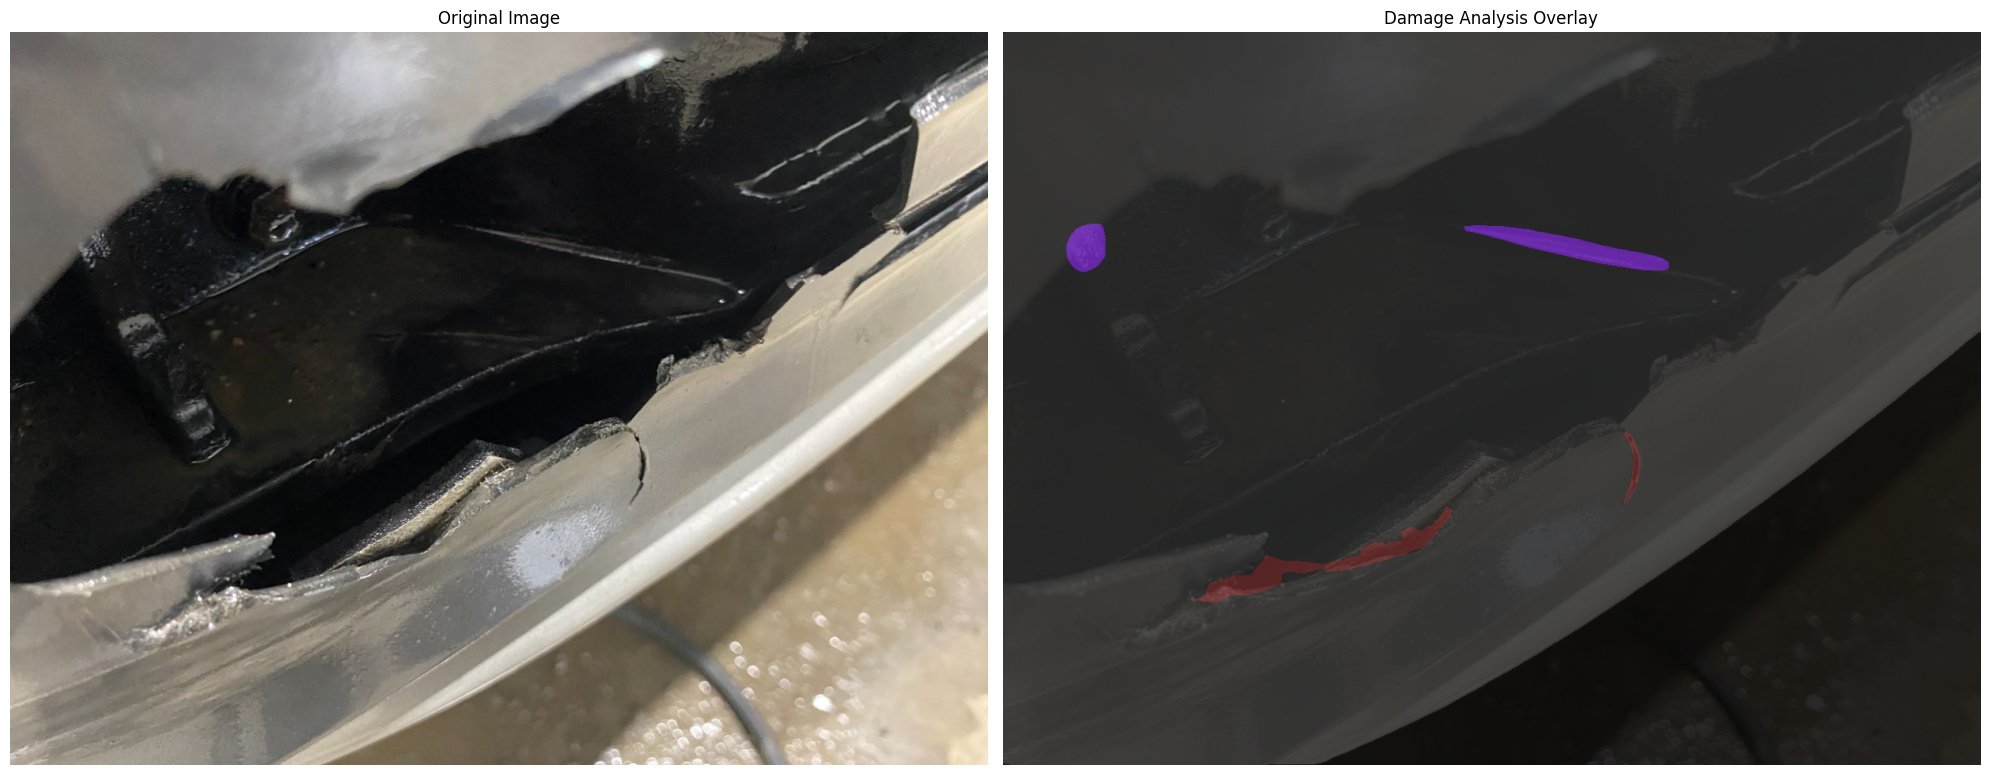


Analysis for image: /shared/datasets/instant_quote_eval/9b0d9cd1-cecf-5408-9a67-034d48824647.jpg
--------------------------------------------------

Panel: fbumper

Damage Type: split/crack
Size: 0.79%
Number of components: 2
Position: x=0.36, y=0.71
On edge: False
--------------------

Damage Type: scratch
Size: 0.81%
Number of components: 2
Position: x=0.42, y=0.29
On edge: False
--------------------


In [36]:
import matplotlib.pyplot as plt
from src.utils import analyze_single_image

path = image_level_df.image_path.tolist()[3]

analyze_single_image(path, matched_results, image_level_df)

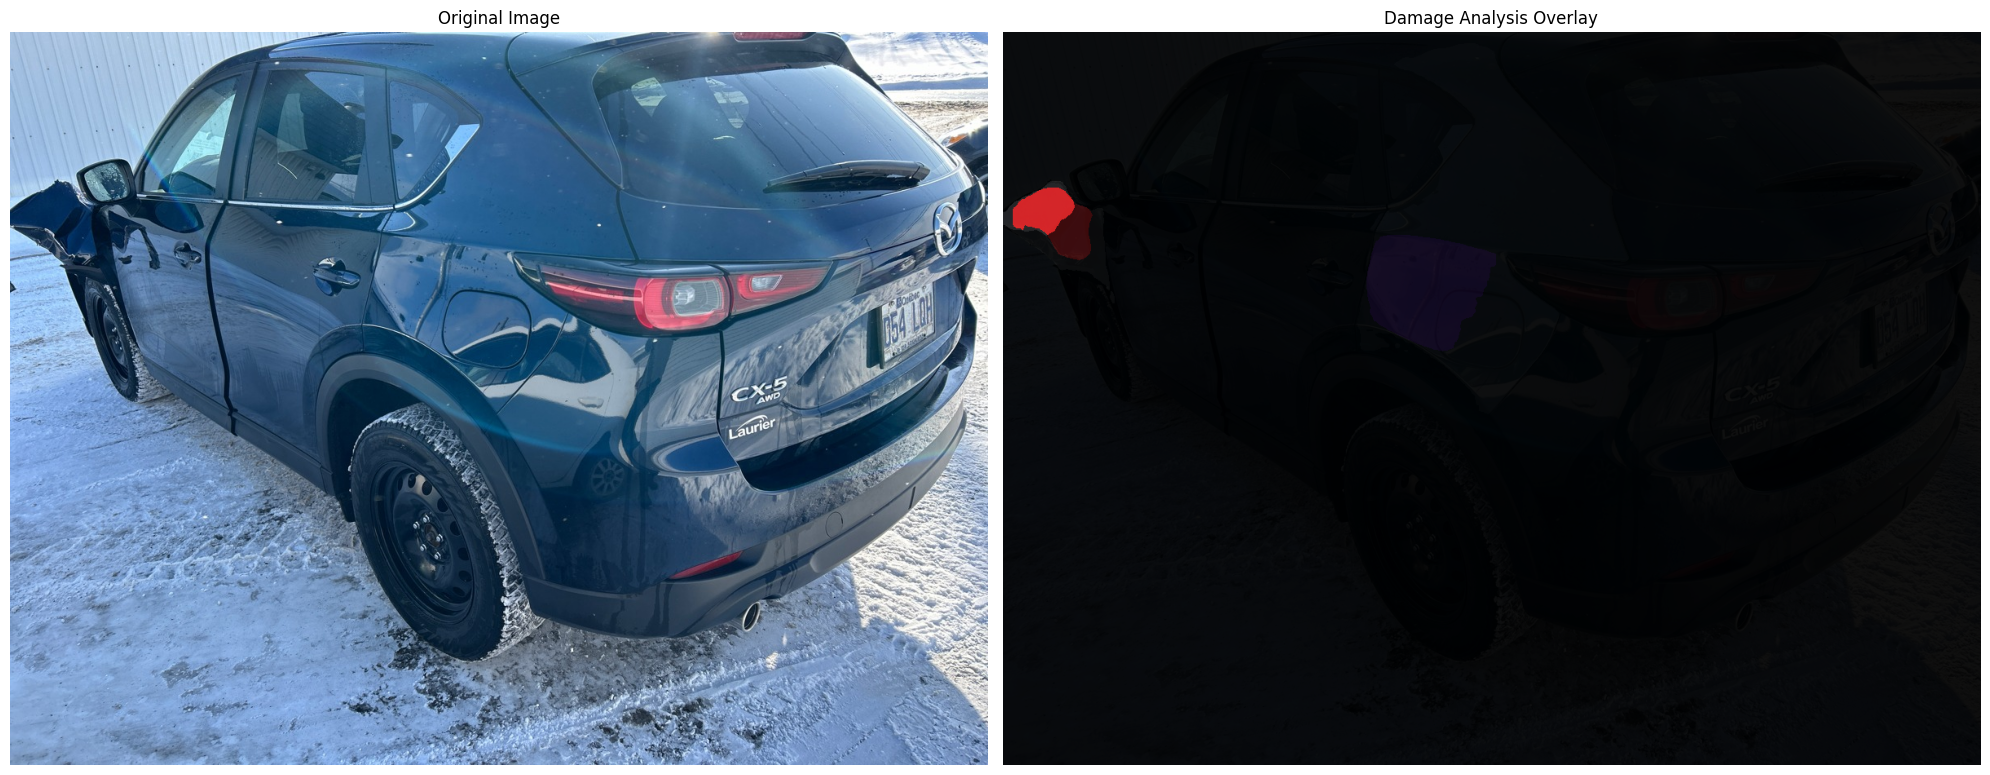


Analysis for image: /shared/datasets/instant_quote_eval/19c7b351-f408-5bba-8f0d-10395b72ed90.jpg
--------------------------------------------------

Panel: blwing

Damage Type: dent
Size: 22.16%
Number of components: 1
Position: x=0.25, y=0.66
On edge: True
--------------------

Panel: bonnet

Damage Type: structural_panel_damage
Size: 80.52%
Number of components: 1
Position: x=0.56, y=0.53
On edge: True
--------------------

Panel: flwing

Damage Type: structural_panel_damage
Size: 58.12%
Number of components: 1
Position: x=0.48, y=0.32
On edge: True
--------------------


In [38]:
path = image_level_df.image_path.tolist()[15]

analyze_single_image(path, matched_results, image_level_df)

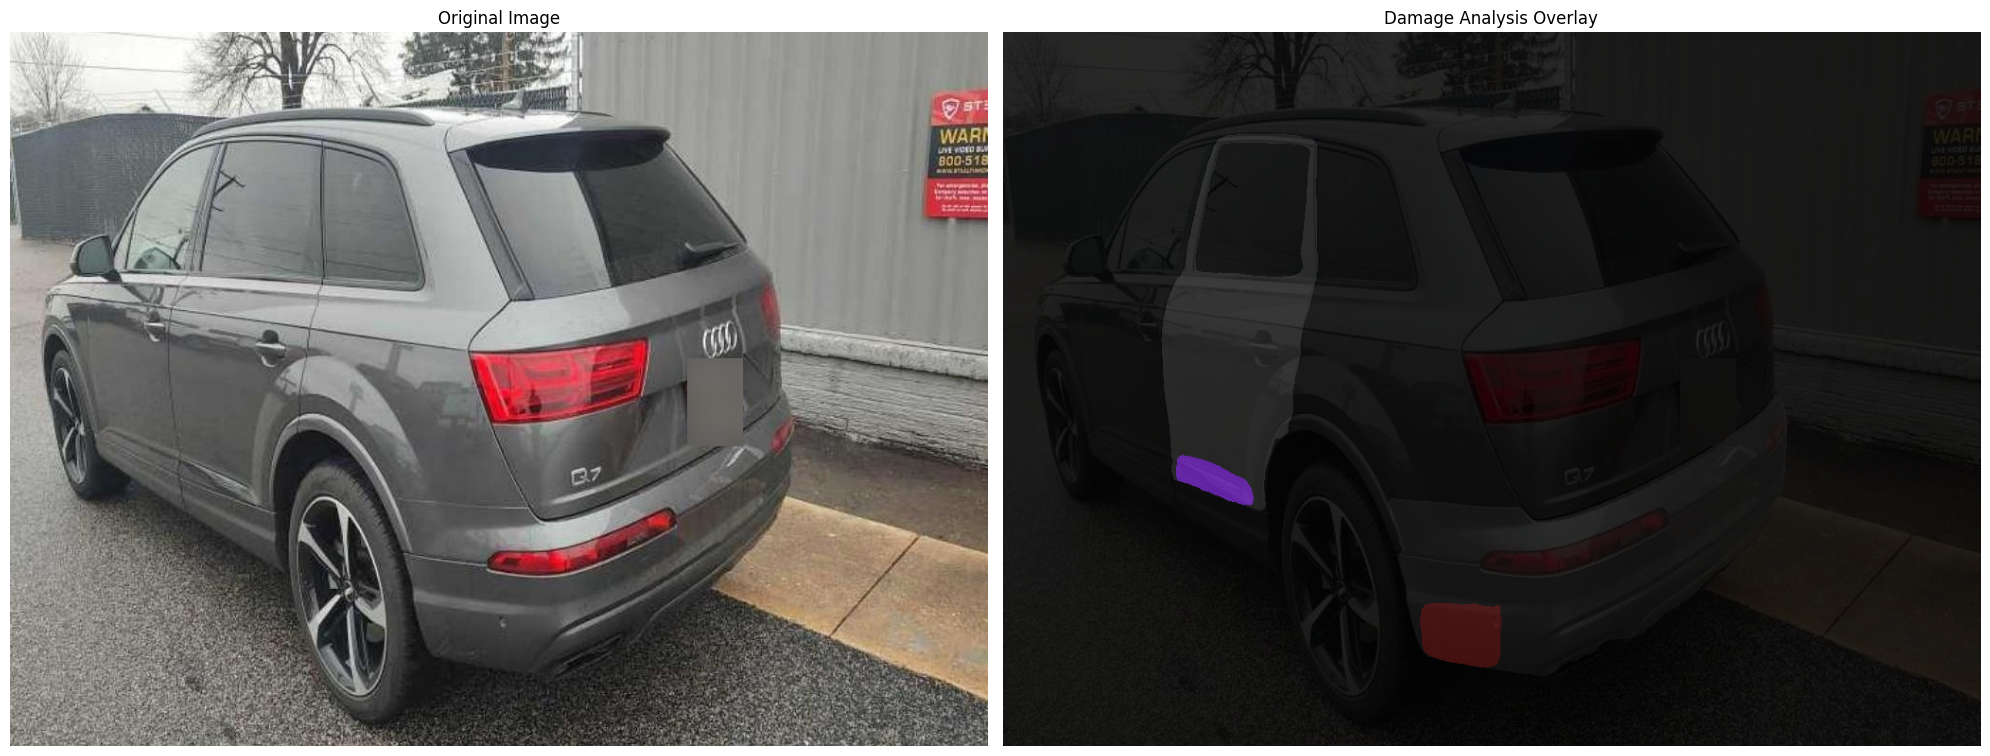


Analysis for image: /shared/datasets/instant_quote_eval/6d7d24ba-931d-4d1c-8fc2-f1da3cf502e8.jpg
--------------------------------------------------

Panel: bbumper

Damage Type: other_surface_damage
Size: 8.32%
Number of components: 1
Position: x=0.19, y=0.85
On edge: True
--------------------

Panel: rldoor

Damage Type: dent
Size: 6.81%
Number of components: 1
Position: x=0.34, y=0.92
On edge: True
--------------------


In [122]:
path = image_level_df.image_path.tolist()[5]

analyze_single_image(path, matched_results, image_level_df)

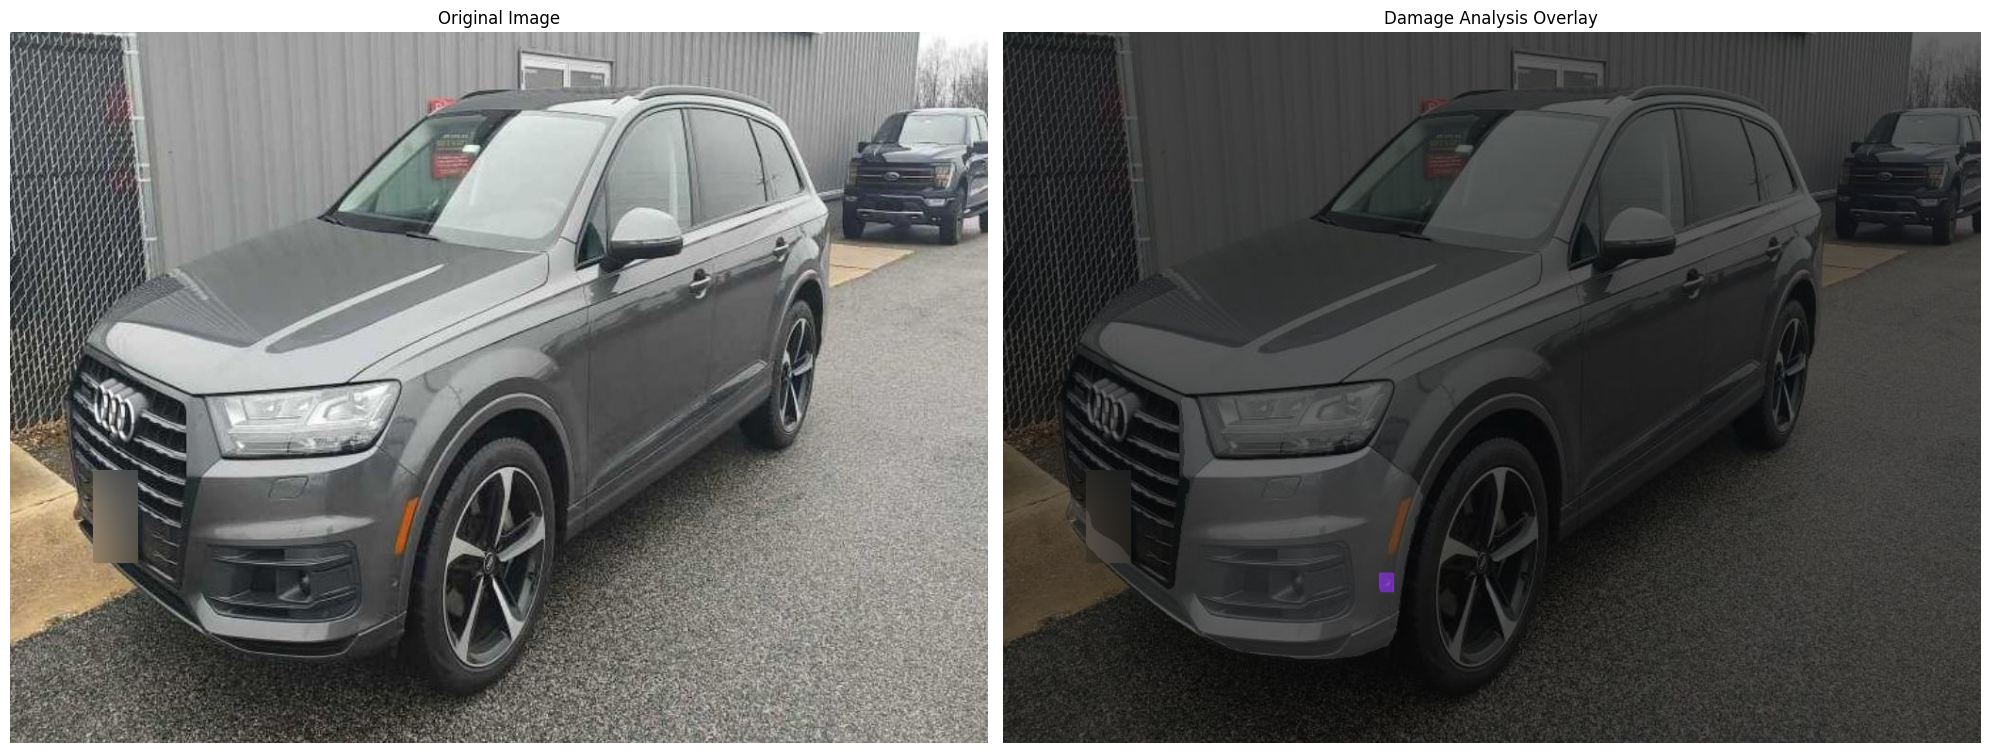


Analysis for image: /shared/datasets/instant_quote_eval/5ec55734-851a-47b0-b9b2-024fafb3c3c1.jpg
--------------------------------------------------

Panel: fbumper

Damage Type: scratch
Size: 0.61%
Number of components: 1
Position: x=0.90, y=0.71
On edge: False
--------------------


In [125]:
path = image_level_df.image_path.tolist()[7]

analyze_single_image(path, matched_results, image_level_df)

In [29]:
from src.claim_utils import aggregate_by_imbag

image_level_df_complete = image_level_df[image_level_df['imbag_id']!='']
image_level_df_complete = image_level_df_complete.rename(columns={'num_components': 'count'})
claim_level_df = aggregate_by_imbag(image_level_df_complete)
print(len(claim_level_df))
claim_level_df.head()

104993


imbag_id    panel           damage_type  \
0  0005e775-66ca-4535-b4e5-3a26a546bec0   brwing                  dent   
1  0005e775-66ca-4535-b4e5-3a26a546bec0   brwing  other_surface_damage   
2  0005e775-66ca-4535-b4e5-3a26a546bec0  fbumper               scratch   
3  0005e775-66ca-4535-b4e5-3a26a546bec0   fldoor                  dent   
4  0005e775-66ca-4535-b4e5-3a26a546bec0   flwing                  dent   

   max_damage_size  average_damage_size  damage_on_edge  whole_panel_visible  \
0        23.571741            23.571741            True                 True   
1        11.405937            11.018202            True                 True   
2         2.295431             2.295431           False                False   
3        55.262438            30.234185           False                 True   
4        10.404751            10.404751            True                 True   

   count  max_damage_size_visible  average_damage_size_visible  \
0      1                23.571741                    23.571741   
1      2                10.630467                    10.630467   
2      2                      NaN                          NaN   
3      1                 5.205933                     5.205933   
4      1                10.404751                    10.404751   

                                            image_id  
0  [d551b577-e77c-4780-8816-908a962acc03, 6e81425...  
1  [d551b577-e77c-4780-8816-908a962acc03, 6e81425...  
2             [5b278360-c8f3-4e41-9f02-17113aa376d3]  
3  [5b278360-c8f3-4e41-9f02-17113aa376d3, 77fbe8f...  
4             [5b278360-c8f3-4e41-9f02-17113aa376d3]

In [145]:
image_level_df_complete.head()

image_path    panel damage_type  \
8   /shared/datasets/instant_quote_eval/c43da123-2...   rrdoor     scratch   
9   /shared/datasets/instant_quote_eval/c43da123-2...   brwing     scratch   
10  /shared/datasets/instant_quote_eval/4bf1e919-8...   rrdoor     scratch   
11  /shared/datasets/instant_quote_eval/43c81de8-a...   bonnet     scratch   
12  /shared/datasets/instant_quote_eval/8c4c621c-8...  bbumper     scratch   

    damage_size  damage_on_edge  whole_panel_visible  num_components  \
8      1.689673           False                False               2   
9      6.920127           False                False               1   
10     0.874023           False                False               1   
11     6.693669           False                 True               1   
12     6.519987            True                False               6   

    relative_x  relative_y                              imbag_id  \
8     0.635758    0.547176  64a6c20f-9e83-42e9-9ed1-72869d3e8a13   
9     0.733278    0.837121  64a6c20f-9e83-42e9-9ed1-72869d3e8a13   
10    0.403249    0.560250  64a6c20f-9e83-42e9-9ed1-72869d3e8a13   
11    0.429700    0.466704  64a6c20f-9e83-42e9-9ed1-72869d3e8a13   
12    0.296224    0.154059  64a6c20f-9e83-42e9-9ed1-72869d3e8a13   

                                image_id  
8   c43da123-21f5-5f0e-a63d-1be212b93579  
9   c43da123-21f5-5f0e-a63d-1be212b93579  
10  4bf1e919-878e-587c-bcf4-b43a834e24d1  
11  43c81de8-a0db-56d9-9533-e8d24dd71a27  
12  8c4c621c-8d11-50b5-8013-4a4a22d2d8ce

### Add repair labour hours and client

In [31]:
imbag_ids = claim_level_df.imbag_id.tolist()
panels = claim_level_df.panel.tolist()

rlhs = []
clients = []
for imbag_id, panel in zip(imbag_ids, panels):
    try:
        rlh = float(imbag2rlh[imbag_id][panel])
    except:
        rlh = None
    try:
        client = imbag2client[imbag_id]
    except:
        client = None
    rlhs.append(rlh)
    clients.append(client)
claim_level_df['repair_labour_hours'] = rlh
claim_level_df['client_id'] = clients
claim_level_df.head()

imbag_id    panel           damage_type  \
0  0005e775-66ca-4535-b4e5-3a26a546bec0   brwing                  dent   
1  0005e775-66ca-4535-b4e5-3a26a546bec0   brwing  other_surface_damage   
2  0005e775-66ca-4535-b4e5-3a26a546bec0  fbumper               scratch   
3  0005e775-66ca-4535-b4e5-3a26a546bec0   fldoor                  dent   
4  0005e775-66ca-4535-b4e5-3a26a546bec0   flwing                  dent   

   max_damage_size  average_damage_size  damage_on_edge  whole_panel_visible  \
0        23.571741            23.571741            True                 True   
1        11.405937            11.018202            True                 True   
2         2.295431             2.295431           False                False   
3        55.262438            30.234185           False                 True   
4        10.404751            10.404751            True                 True   

   count  max_damage_size_visible  average_damage_size_visible  \
0      1                23.571741                    23.571741   
1      2                10.630467                    10.630467   
2      2                      NaN                          NaN   
3      1                 5.205933                     5.205933   
4      1                10.404751                    10.404751   

                                            image_id repair_labour_hours  \
0  [d551b577-e77c-4780-8816-908a962acc03, 6e81425...                None   
1  [d551b577-e77c-4780-8816-908a962acc03, 6e81425...                None   
2             [5b278360-c8f3-4e41-9f02-17113aa376d3]                None   
3  [5b278360-c8f3-4e41-9f02-17113aa376d3, 77fbe8f...                None   
4             [5b278360-c8f3-4e41-9f02-17113aa376d3]                None   

     client_id  
0  geico_subro  
1  geico_subro  
2  geico_subro  
3  geico_subro  
4  geico_subro

In [32]:
claim_level_df.to_parquet('./data/IQ_claim_level_full.parquet')

In [ ]:
/userdata/karolina.dabkowska/mask2features/data/IQ_claim_level_full.parquet

In [118]:
def visualize_damage_analysis(
    image_path: str,
    matched_results: Dict,
    features_df: Optional[pd.DataFrame] = None,
    figsize: tuple = (20, 10)
) -> None:
    """
    Visualize damage analysis with original image and mask overlays.
    Now correctly handles separate panel and damage masks.
    """
    # Read image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot original image
    ax1.imshow(img)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    # Plot image with masks overlay
    ax2.imshow(img)
    
    # Generate colors for different damage types
    unique_damage_types = {
        damage_dict['damage'].category_id 
        for panel_damages in matched_results.values() 
        for damage_dict in panel_damages.values()
    }
    damage_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_damage_types)))
    color_map = dict(zip(unique_damage_types, damage_colors))
    
    # For each panel
    for panel_id, damage_dict in matched_results.items():
        for damage_cat_id, instances_dict in damage_dict.items():
            # Get panel mask from panel instance
            panel_mask = mask_utils.decode(instances_dict['panel'].segmentation)
            damage_mask = mask_utils.decode(instances_dict['damage'].segmentation)
            
            # Create panel overlay
            panel_overlay = np.zeros_like(img)
            panel_overlay[panel_mask > 0] = [255, 255, 255]  # White for panels
            ax2.imshow(panel_overlay, alpha=0.2)
            
            # Create damage overlay
            damage_overlay = np.zeros_like(img)
            color = (np.array(color_map[instances_dict['damage'].category_id][:3]) * 255).astype(int)
            damage_overlay[damage_mask > 0] = color
            ax2.imshow(damage_overlay, alpha=0.5)
            
            # Add centroid marker
            #y_coords, x_coords = np.where(damage_mask)
            #if len(x_coords) > 0:
            #    centroid_x = np.mean(x_coords)
            #    centroid_y = np.mean(y_coords)
            #    ax2.plot(centroid_x, centroid_y, 'r*', markersize=10)
    
    ax2.set_title("Damage Analysis Overlay")
    ax2.axis('off')
    
    
    plt.tight_layout()
    plt.show()

def analyze_single_image(
    image_path: str,
    matched_results: Dict,
    features_df: pd.DataFrame
) -> None:
    """
    Perform complete analysis visualization for a single image.
    """
    if image_path not in matched_results:
        print(f"No analysis results found for image: {image_path}")
        return
    
    # Visualize
    visualize_damage_analysis(
        image_path,
        matched_results[image_path],  # Pass just the results for this image
        features_df
    )
    
    # Print detailed features
    print_image_features(image_path, features_df)

In [58]:
def print_image_features(image_path: str, features_df: pd.DataFrame) -> None:
    """
    Print detailed features for a specific image.
    
    Args:
        image_path: Path to image to analyze
        features_df: DataFrame containing computed features
    """
    image_features = features_df[features_df['image_path'] == image_path]
    
    if image_features.empty:
        print(f"No features found for image: {image_path}")
        return
    
    print(f"\nAnalysis for image: {image_path}")
    print("-" * 50)
    
    # Group by panel
    for panel, panel_data in image_features.groupby('panel'):
        print(f"\nPanel: {panel}")
        print("=" * 30)
        
        for _, damage in panel_data.iterrows():
            print(f"\nDamage Type: {damage['damage_type']}")
            print(f"Size: {damage['damage_size']:.2f}%")
            print(f"Number of components: {damage['num_components']}")
            print(f"Position: x={damage['relative_x']:.2f}, y={damage['relative_y']:.2f}")
            print(f"On edge: {damage['damage_on_edge']}")
            print("-" * 20)